In [13]:
from __future__ import annotations
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]='1'
import torch
from typing import Any
import numpy as np
import cv2

from facefusion.types import VisionFrame

# ---------------------------
# Internal helpers
# ---------------------------

def _as_numpy(arr: Any) -> np.ndarray:
    """
    Accepts a NumPy array or a PyTorch tensor. If it's a tensor, detach+cpu+numpy.
    """
    if isinstance(arr, np.ndarray):
        return arr
    # PyTorch-like tensor
    if hasattr(arr, "detach") and hasattr(arr, "cpu") and hasattr(arr, "numpy"):
        return arr.detach().cpu().numpy()
    raise TypeError("Expected a NumPy array or a PyTorch tensor.")

def _to_uint8_0_255(x: np.ndarray) -> np.ndarray:
    """
    Normalize to [0,255] uint8. Handles common cases:
    - [-1, 1] float -> scale
    - [0, 1] float  -> scale
    - otherwise assumes already in [0,255]
    """
    x = x.astype(np.float32, copy=False)
    vmin, vmax = float(x.min()), float(x.max())
    if vmin >= -1.01 and vmax <= 1.01:
        x = x * 127.5 + 127.5
    elif vmin >= 0.0 and vmax <= 1.0:
        x = x * 255.0
    x = np.clip(x, 0.0, 255.0)
    return x.astype(np.uint8)

def _hwc3_bgr(img: np.ndarray) -> VisionFrame:
    """
    Ensure output is HWC, 3 channels, BGR, uint8, contiguous.
    """
    if img.ndim != 3:
        raise ValueError(f"Expected 3D array (HWC or CHW), got shape {img.shape}")

    # If CHW, convert to HWC
    if img.shape[0] in (1, 3, 4) and (img.shape[2] not in (1, 3, 4)):
        img = np.transpose(img, (1, 2, 0))

    # Drop alpha if present
    if img.shape[2] == 4:
        img = img[:, :, :3]

    # If grayscale, expand to 3 channels
    if img.shape[2] == 1:
        img = cv2.cvtColor(_to_uint8_0_255(img), cv2.COLOR_GRAY2BGR)
        return np.ascontiguousarray(img, dtype=np.uint8)

    # Assume RGB → convert to BGR
    img = _to_uint8_0_255(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return np.ascontiguousarray(img, dtype=np.uint8)

# ---------------------------
# 1) From a StyleGAN generator output tensor
# ---------------------------

def visionframe_from_stylegan(tensor: Any, select: int = 0) -> VisionFrame:
    """
    Convert a StyleGAN(2) output to VisionFrame.
    Accepts:
      - torch.Tensor or np.ndarray
      - shape (C,H,W) or (N,C,H,W) or (H,W,C) or (N,H,W,C)
    Values can be in [-1,1], [0,1], or [0,255].
    """
    arr = _as_numpy(tensor)

    # Handle batch dimension
    if arr.ndim == 4:
        arr = arr[select]  # pick one sample

    if arr.ndim != 3:
        raise ValueError(f"Expected 3D tensor after batching, got shape {arr.shape}")

    return _hwc3_bgr(arr)

# ---------------------------
# 2) From a PIL.Image.Image
# ---------------------------

def visionframe_from_pil(pil_image: "Image.Image") -> VisionFrame:
    """
    Convert a PIL image to VisionFrame, respecting EXIF orientation.
    """
    try:
        from PIL import ImageOps
    except ImportError as e:
        raise ImportError("Pillow is required for visionframe_from_pil.") from e

    pil_image = ImageOps.exif_transpose(pil_image).convert("RGB")
    rgb = np.array(pil_image, dtype=np.uint8)  # HWC, RGB
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    return np.ascontiguousarray(bgr, dtype=np.uint8)

# ---------------------------
# 3) From a path to an image
# ---------------------------

def visionframe_from_path(path: str) -> VisionFrame:
    """
    Load an image from disk and return a VisionFrame (BGR, uint8).
    Uses PIL to handle EXIF orientation correctly.
    """
    try:
        from PIL import Image, ImageOps
    except ImportError as e:
        raise ImportError("Pillow is required for visionframe_from_path.") from e

    with Image.open(path) as im:
        im = ImageOps.exif_transpose(im).convert("RGB")
        rgb = np.array(im, dtype=np.uint8)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    return np.ascontiguousarray(bgr, dtype=np.uint8)

In [14]:
from quality_metrics import *

In [15]:
from PIL import Image
from facefusion_wrapper import init_facefusion_state, ensure_facefusion_models
from quality_metrics import *          # the metric we wrote

# 1) Initialize state like the CLI would
init_facefusion_state(
    detector_model="retinaface",
    detector_size="640x640",
    detector_score=0.75,
    detector_angles=(0,),         # add 90/-90 if you need rotated detection
    use_landmarker_68=True,      # set True if you want real 68-pt landmarks
    landmarker_score=0.5,
    download_scope="full",
)

# 2) Ensure models are downloaded & inference pools are ready
ensure_facefusion_models(use_landmarker_68=True)


In [16]:
# # 3) Run your pipeline
# import os
# for im in os.listdir("/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img"):
#     if im.endswith(".pt") or im.startswith("."):
#         continue

    
#     print(im)
#     vf = visionframe_from_pil(Image.open(f"/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/{im}"))
#     reject, score, subs, reasons = should_reject(vf)
#     if reject:
#         os.remove(f"/Users/adamsobieszek/PycharmProjects/_manipy/age_oems_img/{im}")
#     print(reject, score, reasons)
#     print(subs)
# 3) Run your pipeline
from quality_metrics import _crop_from_bbox, _scale01, _has_68, _geom_symmetry_score, _estimate_pose_from_68, _clamp01, _laplacian_var, _centering_score, _occlusion_score
import os
import shutil



import os
rej = 0
to_remove = []
all_reasons = []
os.makedirs("/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional3/rejected_face_metrics", exist_ok=True)
for im in os.listdir("/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional3"):
    if im.endswith(".pt") or im.startswith(".") or not 'jpg' in im:
        continue


    vf = visionframe_from_pil(Image.open(f"/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional3/{im}").resize((256,256)))
    reject, score, subs, reasons = should_reject(vf)

    # metrics = [
    #     # new edge-partial metrics
    #     # m_edge_partial,
    #     make_edge_fire("left"), make_edge_fire("right"),
    #     # make_edge_fire("top"),  make_edge_fire("bottom"),
    #     # m_edge_color_partial, m_edge_color_max_sim 
    #     # (optional debug)
    #     # make_edge_score("left"), make_edge_skin_frac("left"), ...
    # ]
    # values = evaluate_metrics(vf, metrics)
    # reject = (values.get("edge_left_fire", 0.0) >= 0.5) or (values.get("edge_right_fire", 0.0) >= 0.5)
    if reject:
        if rej%100==0:
            print(rej)
        rej +=1
        to_remove.append(im)
        # all_reasons.append(reasons)
        shutil.move(f"/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional3/{im}", f"/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional3/rejected_face_metrics/{im}")
        # if reasons == ["landmark_geometry_implausible"]:
print(reject, score, reasons)
print(subs)
print(all_reasons)

{'have_68': True, 'len_5': 5, 'lap_var': 824.5879426848888, 'mean': 151.0980521262003, 'std': 73.74237428882469, 'yaw_pitch_roll': (1.453731463530133, 58.24669680574795, -1.3509761095046997)}
{'have_68': True, 'len_5': 5, 'lap_var': 222.56603713703257, 'mean': 93.49672202797203, 'std': 47.56995993435352, 'yaw_pitch_roll': (0.10289692354955951, -24.941466668751847, -0.11632030457258224)}
{'have_68': True, 'len_5': 5, 'lap_var': 251.33148564304437, 'mean': 116.12865466101695, 'std': 39.971840258564086, 'yaw_pitch_roll': (-2.316541019304447, 37.10909749587302, 0.20465759932994843)}
{'have_68': True, 'len_5': 5, 'lap_var': 553.2036838634896, 'mean': 154.05759885416134, 'std': 55.26678914768132, 'yaw_pitch_roll': (-1.0990503523723587, 3.392706027778289, 0.15638388693332672)}
{'have_68': True, 'len_5': 5, 'lap_var': 1193.1210611453298, 'mean': 124.82758620689656, 'std': 45.66959259316161, 'yaw_pitch_roll': (-4.491356239591607, 21.881027503658252, -0.6075028777122498)}
{'have_68': True, 'len_

KeyboardInterrupt: 

In [56]:
%cd /Users/adamsobieszek/PycharmProjects/_manipy/deixis

import os
import torch
import torch.nn.functional as F
from metrics.metric_utils import *

# ---------- PR helpers (from your snippet) ----------
@torch.no_grad()
def compute_distances(row_features, col_features, num_gpus, rank, col_batch_size):
    assert 0 <= rank < num_gpus
    num_cols = col_features.shape[0]
    num_batches = ((num_cols - 1) // col_batch_size // num_gpus + 1) * num_gpus
    col_batches = torch.nn.functional.pad(col_features, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
    dist_batches = []
    for col_batch in col_batches[rank :: num_gpus]:
        dist_batch = torch.cdist(row_features.unsqueeze(0), col_batch.unsqueeze(0))[0]
        for src in range(num_gpus):
            dist_broadcast = dist_batch.clone()
            if num_gpus > 1:
                torch.distributed.broadcast(dist_broadcast, src=src)
            dist_batches.append(dist_broadcast.cpu() if rank == 0 else None)
    return torch.cat(dist_batches, dim=1)[:, :num_cols] if rank == 0 else None
from types import SimpleNamespace
import torch

@torch.no_grad()
def pr_per_sample_from_dir_and_tensors(
    real_dir: str,
    gen_imgs: torch.Tensor,
    *,
    nhood_size: int = 3,
    row_batch_size: int = 512,
    col_batch_size: int = 1024,
    device: str = "cuda",
    dataset_xflip: bool = False,
    real_features=None
):
    from torch.nn import functional as F

    # --- normalize gen tensors to [-1,1]
    assert gen_imgs.ndim == 4 and gen_imgs.shape[1] == 3, "gen_imgs must be [N,3,H,W]"
    x = gen_imgs.to(torch.float32)
    if x.min().item() >= -1.01 and x.max().item() <= 1.01:
        pass
    elif x.min().item() >= 0.0 and x.max().item() <= 1.0:
        x = x * 2 - 1
    elif x.min().item() >= 0.0 and x.max().item() <= 255.0:
        x = x / 127.5 - 1.0
    else:
        raise ValueError("Unexpected gen tensor range")
    gen_imgs = x.to(device, dtype=torch.float32, non_blocking=True)

    
    progress = metric_utils.ProgressMonitor(verbose=True)

    # opts = metric_utils.MetricOptions()    # Validate arguments.
    opts = metric_utils.MetricOptions(
        device=torch.device(device),
        num_gpus=1,
        rank=0,
        cache=None,
        progress=progress,
        dataset_kwargs=dict(
            class_name="training.dataset.ImageFolderDataset",  # <-- THIS was missing
            path=real_dir,
            use_labels=False,
            xflip=dataset_xflip,
            max_size=None,
            # resolution not required; the VGG16 detector resizes internally
        ),
    )

    detector_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/vgg16.pkl"
    detector_kwargs = dict(return_features=True)

    # --- REAL features (pass batch_size explicitly)
    real_feats = (real_features if real_features is not None else compute_feature_stats_for_dataset(
        opts=opts, detector_url=detector_url, detector_kwargs=detector_kwargs,
        rel_lo=0, rel_hi=0, capture_all=True, max_items=None, batch_size=row_batch_size,
        data_loader_kwargs=dict(num_workers=0),   # macOS/MPS often safer with 0 workers
    ).get_all_torch()).to(torch.float32).to(opts.device)

    # --- GEN features via the same detector
    try:
        detector = metric_utils.get_feature_detector(detector_url, device=opts.device)
        detector.eval().requires_grad_(False)
        def run_det(b): 
            # print input kwargs
            out = detector(b, **detector_kwargs)
            return out if isinstance(out, torch.Tensor) else out[0]
    except Exception:
        def run_det(b):
            return metric_utils.compute_feature_detector_output(
                b, detector_url, detector_kwargs, device=opts.device
            )

    gen_feats_list = []
    for s in range(0, gen_imgs.shape[0], row_batch_size):
        feats = run_det(gen_imgs[s:s+row_batch_size].to(dtype=torch.float32))
        gen_feats_list.append(feats.to(torch.float32))
    gen_feats = torch.cat(gen_feats_list, dim=0).to(opts.device)

    # --- distance helpers (same as before)
    @torch.no_grad()
    def compute_distances(row_features, col_features, num_gpus, rank, col_batch_size):
        assert 0 <= rank < num_gpus
        num_cols = col_features.shape[0]
        num_batches = ((num_cols - 1) // col_batch_size // num_gpus + 1) * num_gpus
        col_batches = torch.nn.functional.pad(col_features, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
        dist_batches = []
        for col_batch in col_batches[rank :: num_gpus]:
            dist_batch = torch.cdist(row_features.unsqueeze(0), col_batch.unsqueeze(0))[0]
            for src in range(num_gpus):
                dist_broadcast = dist_batch.clone()
                if num_gpus > 1:
                    torch.distributed.broadcast(dist_broadcast, src=src)
                dist_batches.append(dist_broadcast.cpu() if rank == 0 else None)
        return torch.cat(dist_batches, dim=1)[:, :num_cols] if rank == 0 else None

    def kth_radii(manifold):
        out = []
        for mb in manifold.split(row_batch_size):
            dist = compute_distances(mb, manifold, num_gpus=opts.num_gpus, rank=opts.rank, col_batch_size=col_batch_size)
            out.append(dist.to(torch.float32).kthvalue(nhood_size + 1).values.to(torch.float32))
        return torch.cat(out, dim=0)

    kth_real = kth_radii(real_feats)
    kth_gen  = kth_radii(gen_feats)

    # precision flags for generated samples (probes = gen, manifold = real)
    prec_flags = []
    for pb in gen_feats.split(row_batch_size):
        dist = compute_distances(pb, real_feats, num_gpus=opts.num_gpus, rank=opts.rank, col_batch_size=col_batch_size)
        prec_flags.append((dist <= kth_real).any(dim=1))
    prec_flags = torch.cat(prec_flags, dim=0)

    # recall flags for real samples (probes = real, manifold = gen)
    rec_flags = []
    for pb in real_feats.split(row_batch_size):
        dist = compute_distances(pb, gen_feats, num_gpus=opts.num_gpus, rank=opts.rank, col_batch_size=col_batch_size)
        rec_flags.append((dist <= kth_gen).any(dim=1))
    rec_flags = torch.cat(rec_flags, dim=0)

    P = float(prec_flags.float().mean().item())
    R = float(rec_flags.float().mean().item())
    return prec_flags, rec_flags, P, R

import torch
from types import SimpleNamespace

@torch.no_grad()
def realness_precision_score_from_dir_and_tensors(
    real_dir: str ='',
    fake_dir: str ='',                 # [N,3,H,W] in [-1,1] or [0,1] or uint8
    *,
    gen_imgs: torch.Tensor | None = None,
    nhood_size: int = 3,                    # k for real-manifold radii
    row_batch_size: int = 128,
    col_batch_size: int = 256,
    device: str = "cuda",
    dataset_xflip: bool = False,
    real_features: torch.Tensor | None = None,  # optional cache: [N_real, C] fp32
    fake_features: torch.Tensor | None = None,  # optional cache: [N_fake, C] fp32
    alpha: float = 2.0,                     # softness of the score mapping
    return_extra: bool = True,              # include nn idx/dist/radius
    verbose: bool = False,
):
    """
    Continuous precision-only 'realness' score for few fake images.
    Scores in [0,1], higher is more real-like.

    Returns:
        scores: FloatTensor [N_gen] in [0,1]
        extras (optional): dict with keys
            'min_ratio' [N_gen]        (dimensionless)
            'nn_index'  [N_gen] (long) (index into real set)
            'nn_dist'   [N_gen]        (distance to best real)
            'nn_radius' [N_gen]        (k-th radius of that real)
            'k'         int
    """
    # --- normalize generated images to [-1,1], fp32 on device
    if gen_imgs is not None:
        assert gen_imgs.ndim == 4 and gen_imgs.shape[1] == 3, "gen_imgs must be [N,3,H,W]"
        x = gen_imgs.to(torch.float32)
        xmin, xmax = float(x.min()), float(x.max())
        if xmin >= -1.01 and xmax <= 1.01:
            pass
        elif xmin >= 0.0 and xmax <= 1.0:
            x = x * 2 - 1
        elif xmin >= 0.0 and xmax <= 255.0:
            x = x / 127.5 - 1.0
        else:
            raise ValueError(f"Unexpected gen tensor range [{xmin:.3f},{xmax:.3f}]")
        gen_imgs = x.to(device, dtype=torch.float32, non_blocking=True)

    # --- metric utils wiring (matches your new calling style)
    
    progress = metric_utils.ProgressMonitor(verbose=verbose)
    opts = metric_utils.MetricOptions(
        device=torch.device(device),
        num_gpus=1,
        rank=0,
        cache=None,
        progress=progress,
        dataset_kwargs=dict(
            class_name="training.dataset.ImageFolderDataset",
            path=real_dir,
            use_labels=False,
            xflip=dataset_xflip,
            max_size=None,
        ),
    )

    detector_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/vgg16.pkl"
    detector_kwargs = dict(return_features=True)

    # --- REAL features (compute or reuse)
    if real_features is None:
        real_feats = metric_utils.compute_feature_stats_for_dataset(
            opts=opts, detector_url=detector_url, detector_kwargs=detector_kwargs,
            rel_lo=0, rel_hi=0, capture_all=True, max_items=None,
            batch_size=row_batch_size, data_loader_kwargs=dict(num_workers=0),
        ).get_all_torch().to(torch.float32).to(opts.device)
    else:
        real_feats = real_features.to(torch.float32).to(opts.device)

    if fake_features is None:
        # --- GEN features via the same detector (fp32)
        if gen_imgs is not None:
            try:
                detector = metric_utils.get_feature_detector(detector_url, device=opts.device)
                detector.eval().requires_grad_(False)
                def run_det(b):
                    out = detector(b, **detector_kwargs)
                    return out if isinstance(out, torch.Tensor) else out[0]
            except Exception:
                def run_det(b):
                    return metric_utils.compute_feature_detector_output(
                        b, detector_url, detector_kwargs, device=opts.device
                    )
            
            gen_feats_list = []
            for s in range(0, gen_imgs.shape[0], row_batch_size):
                feats = run_det(gen_imgs[s:s+row_batch_size])          # detector prefers fp32
                gen_feats_list.append(feats.to(torch.float32))
            gen_feats = torch.cat(gen_feats_list, dim=0).to(opts.device)  # [N_gen, C]

        elif fake_dir is not None:
                
            opts_fake = metric_utils.MetricOptions(
                device=torch.device("cpu"),
                num_gpus=1,
                rank=0,
                cache=None,
                progress=progress,
                dataset_kwargs=dict(
                    class_name="training.dataset.ImageFolderDataset",
                    path=fake_dir,
                    use_labels=False,
                    xflip=dataset_xflip,
                    max_size=None,
                ),
            )

            gen_feats = metric_utils.compute_feature_stats_for_dataset(
                opts=opts_fake, detector_url=detector_url, detector_kwargs=detector_kwargs,
                rel_lo=0, rel_hi=0, capture_all=True, max_items=None,
                batch_size=row_batch_size, data_loader_kwargs=dict(num_workers=0),
            ).get_all_torch().to(torch.float32).to(opts.device)
    else:
        gen_feats = fake_features.to(torch.float32).to(opts.device)



    # --- distance helper (fp32)
    def _batched_cdist(rows: torch.Tensor, cols: torch.Tensor) -> torch.Tensor:
        num_cols = cols.shape[0]
        num_batches = ((num_cols - 1) // col_batch_size // 1 + 1) * 1
        col_batches = torch.nn.functional.pad(cols, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
        parts = []
        for cb in col_batches:
            parts.append(torch.cdist(rows.unsqueeze(0), cb.unsqueeze(0), p=2.0)[0])
        return torch.cat(parts, dim=1)[:, :num_cols]  # [rows, cols]

    # --- compute k-th radii for real manifold
    N_real = real_feats.shape[0]
    if nhood_size >= N_real:
        k = max(1, N_real - 1)
    else:
        k = nhood_size

    kth_real = []
    for mb in real_feats.split(row_batch_size):
        dist = _batched_cdist(mb, real_feats)                         # [B, N_real]
        # Use torch.topk to get the (k+1)th smallest value along dim=1 (since topk returns largest, so use negative and reverse)
        # +1 skips self 0
        kth_vals, _ = torch.topk(dist, k + 1, dim=1, largest=False, sorted=True)
        kth_real.append(kth_vals[:, -1])
    kth_real = torch.cat(kth_real, dim=0)                              # [N_real], fp32

    # --- for each gen probe, compute normalized distance ratios to all real anchors
    #     ratio_ij = d(p_i, r_j) / rho_j, then take min over j
    scores = []
    min_ratios = []
    nn_idx_list, nn_dist_list, nn_rad_list = [], [], []

    # Pre-broadcast real radii for vectorized compare
    rho = kth_real  # [N_real]
    eps = 1e-8

    for pb in gen_feats.split(row_batch_size):
        D = _batched_cdist(pb, real_feats)                 # [B, N_real]
        R = rho.unsqueeze(0).expand_as(D) + eps            # [B, N_real]
        ratios = D / R                                     # [B, N_real]
        min_vals, min_idx = ratios.min(dim=1)              # [B], [B]
        # map to (0,1]: score = 1 / (1 + min_ratio^alpha)
        s = 1.0 / (1.0 + torch.clamp(min_vals, min=0.0) ** alpha)
        scores.append(s)

        # extras
        min_ratios.append(min_vals)
        nn_idx_list.append(min_idx)
        # pick corresponding absolute dist & radius
        idx2 = min_idx.unsqueeze(1)
        nn_dist_list.append(D.gather(1, idx2).squeeze(1))
        nn_rad_list.append(R.gather(1, idx2).squeeze(1))

    scores     = torch.cat(scores, dim=0)          # [N_gen]
    min_ratios = torch.cat(min_ratios, dim=0)      # [N_gen]
    nn_index   = torch.cat(nn_idx_list, dim=0).long()
    nn_dist    = torch.cat(nn_dist_list, dim=0)
    nn_radius  = torch.cat(nn_rad_list, dim=0)

    if return_extra:
        extras = dict(
            min_ratio=min_ratios,
            nn_index=nn_index,
            nn_dist=nn_dist,
            nn_radius=nn_radius,
            k=k,
        )
        return scores, extras
    return scores


def compute_feature_stats_for_dataset(opts, detector_url, detector_kwargs, rel_lo=0, rel_hi=1, batch_size=16, data_loader_kwargs=None, max_items=None, detector=None, **stats_kwargs):
    dataset = dnnlib.util.construct_class_by_name(**opts.dataset_kwargs)
    if data_loader_kwargs is None:
        data_loader_kwargs = dict(pin_memory=False, num_workers=0, prefetch_factor=None)

    # Try to lookup from cache.
    cache_file = None
    if opts.cache:
        # Choose cache file name.
        args = dict(dataset_kwargs=opts.dataset_kwargs, detector_url=detector_url, detector_kwargs=detector_kwargs, stats_kwargs=stats_kwargs)
        md5 = hashlib.md5(repr(sorted(args.items())).encode('utf-8'))
        cache_tag = f'{dataset.name}-{get_feature_detector_name(detector_url)}-{md5.hexdigest()}'
        cache_file = dnnlib.make_cache_dir_path('gan-metrics', cache_tag + '.pkl')

        # Check if the file exists (all processes must agree).
        flag = os.path.isfile(cache_file) if opts.rank == 0 else False
        if opts.num_gpus > 1:
            flag = torch.as_tensor(flag, dtype=torch.float32, device=opts.device)
            torch.distributed.broadcast(tensor=flag, src=0)
            flag = (float(flag.cpu()) != 0)

        # Load.
        if flag:
            return FeatureStats.load(cache_file)

    # Initialize.
    num_items = len(dataset)
    if max_items is not None:
        num_items = min(num_items, max_items)
    stats = FeatureStats(max_items=num_items, **stats_kwargs)
    progress = opts.progress.sub(tag='dataset features', num_items=num_items, rel_lo=rel_lo, rel_hi=rel_hi)
    
    detector = detector if detector is not None else build_feature_extractor("vgg16", device=opts.device)
    # detector = #get_feature_detector(url=detector_url, device=opts.device, num_gpus=opts.num_gpus, rank=opts.rank, verbose=progress.verbose)

    # Main loop.
    item_subset = [(i * opts.num_gpus + opts.rank) % num_items for i in range((num_items - 1) // opts.num_gpus + 1)]
    for images, _labels in torch.utils.data.DataLoader(dataset=dataset, sampler=item_subset, batch_size=batch_size, **data_loader_kwargs):
        if images.shape[1] == 1:
            images = images.repeat([1, 3, 1, 1])
        import torchvision.transforms as T
        images = images[:,:,200:, 100:images.size(3)-100]
        images = T.Resize(224)(images)
        if not 'features' in locals(): 
            plt.imshow(images[0].cpu().numpy().transpose(1,2,0))
            plt.show()
        features = detector(images.to(opts.device)/255)#, **detector_kwargs)
        stats.append_torch(features, num_gpus=opts.num_gpus, rank=opts.rank)
        progress.update(stats.num_items)

    # Save to cache.
    if cache_file is not None and opts.rank == 0:
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        temp_file = cache_file + '.' + uuid.uuid4().hex
        stats.save(temp_file)
        os.replace(temp_file, cache_file) # atomic
    return stats


/Users/adamsobieszek/PycharmProjects/_manipy/deixis


In [23]:
import pickle
import sys
device = torch.device('mps')

sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:

    D = pickle.load(fp)['D'].to(device)

# Compute the average latent vector
all_z = torch.randn([1, G.mapping.z_dim], device=device)
face_w = G.mapping(all_z, None, truncation_psi=0.5)


In [57]:
# example_vgg_mps.py
# Import from your file/package (adjust the import to match how you install it)
# If it's a local file named sg_output_analysis.py in the same folder:

import torch
from face_utils.sg_opt.sg_output_analysis import (
    build_feature_extractor,
    CoordsToFeaturesConfig,
    coords_to_features,
    feature_sensitivity_at,
)

# 1) Pick the best available device, preferring Apple MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# # 2) Build the VGG16-based feature extractor on that device
# extractor = build_feature_extractor("vgg16", device=device)
# print("VGG16 feature extractor is ready.")

# # 3) Create a dummy RGB image (1,3,H,W) in [0,1] on the same device
# H, W = 480, 640
# image = torch.rand(1, 3, H, W, device=device)

# # 4) Define a patch centered at the middle of the image and extract features
# center_xy = torch.tensor([W / 2.0, H / 2.0], device=device)  # pixels (x, y)
# cfg = CoordsToFeaturesConfig(
#     extractor_name="vgg16",
#     out_res=224,
#     patch_px=128,
#     coords_mode="pixels",
#     clamp=True,
# )

# feats, patch = coords_to_features(image, center_xy, cfg, extractor)
# print(f"Feature shape: {feats.shape}  |  Patch shape: {patch.shape}")

# # 5) (Optional) Compute gradient/Hessian sensitivity at that coordinate

Using device: mps


In [1]:
%cd /Users/adamsobieszek/PycharmProjects/_manipy/deixis
import dnnlib
import matplotlib.pyplot as plt
import torch
from metrics import metric_utils

#----------------------------------------------------------------------------

@torch.no_grad()
def compute_distances(row_features, col_features, num_gpus, rank, col_batch_size):
    assert 0 <= rank < num_gpus
    num_cols = col_features.shape[0]
    num_batches = ((num_cols - 1) // col_batch_size // num_gpus + 1) * num_gpus
    col_batches = torch.nn.functional.pad(col_features, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
    dist_batches = []
    for col_batch in col_batches[rank :: num_gpus]:
        dist_batch = torch.cdist(row_features.unsqueeze(0), col_batch.unsqueeze(0))[0]
        for src in range(num_gpus):
            dist_broadcast = dist_batch.clone()
            if num_gpus > 1:
                torch.distributed.broadcast(dist_broadcast, src=src)
            dist_batches.append(dist_broadcast.cpu() if rank == 0 else None)
    return torch.cat(dist_batches, dim=1)[:, :num_cols] if rank == 0 else None

#----------------------------------------------------------------------------
@torch.no_grad()
def compute_feats(opts, max_real, batch_size=32, real_features=None, extractor=None):
    detector_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/vgg16.pkl'
    detector_kwargs = dict(return_features=True,resize_images=True)

    detector = build_feature_extractor("vgg16", device=opts.device)
    real_features = (real_features if real_features is not None else compute_feature_stats_for_dataset(
        opts=opts, detector_url=detector_url, detector_kwargs=detector_kwargs, batch_size=batch_size,
        rel_lo=0, rel_hi=0, capture_all=True, max_items=max_real, detector=detector).get_all_torch()).to(torch.float32).to(opts.device)
    return real_features



real_dir="/Users/adamsobieszek/Downloads/0.75"
fake_dir="/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_redo"
progress = metric_utils.ProgressMonitor(verbose=True)

# opts = metric_utils.MetricOptions()    # Validate arguments.
opts = metric_utils.MetricOptions(
    device=torch.device('mps'),
    num_gpus=1,
    rank=0,
    cache=None,
    progress=progress,
    dataset_kwargs=dict(
        class_name="training.dataset.ImageFolderDataset",  
        path=real_dir,
        use_labels=False,
        xflip=False,
        max_size=None,
    ),
)

# real_features = compute_feats(opts, None, real_features=None, batch_size=128)
opts.dataset_kwargs['path'] = fake_dir
fake_features = compute_feats(opts, None, real_features=None, batch_size=128)
scores, extras = realness_precision_score_from_dir_and_tensors(
    real_features=real_features,
    fake_features=fake_features,
    nhood_size=3,
    row_batch_size=4,
    col_batch_size=250,
    device='mps',  
)



print("Scores:", scores.tolist())
print("Nearest real idx:", extras["nn_index"].tolist())
print("Min ratios:", extras["min_ratio"].tolist())      # <1 means inside some radius
print("Nearest dist:", extras["nn_dist"].tolist())
print("Nearest radius:", extras["nn_radius"].tolist())

/Users/adamsobieszek/PycharmProjects/_manipy/deixis


NameError: name 'build_feature_extractor' is not defined

In [63]:
dataset = dnnlib.util.construct_class_by_name(**dict(
        class_name="training.dataset.ImageFolderDataset",  
        path=fake_dir,
        use_labels=False,
        xflip=False,
        max_size=None,
    ))
dataset._image_fnames

['0_f_10.jpg',
 '0_f_12.jpg',
 '0_f_14.jpg',
 '0_f_16.jpg',
 '0_f_18.jpg',
 '0_f_20.jpg',
 '0_f_22.jpg',
 '0_f_24.jpg',
 '0_f_26.jpg',
 '0_f_28.jpg',
 '0_f_30.jpg',
 '0_f_32.jpg',
 '0_f_34.jpg',
 '0_f_40.jpg',
 '0_f_42.jpg',
 '0_f_44.jpg',
 '0_f_46.jpg',
 '0_f_48.jpg',
 '0_f_50.jpg',
 '0_f_52.jpg',
 '0_f_54.jpg',
 '0_f_56.jpg',
 '0_f_8.jpg',
 '0_m_10.jpg',
 '0_m_12.jpg',
 '0_m_14.jpg',
 '0_m_16.jpg',
 '0_m_18.jpg',
 '0_m_20.jpg',
 '0_m_22.jpg',
 '0_m_24.jpg',
 '0_m_26.jpg',
 '0_m_28.jpg',
 '0_m_30.jpg',
 '0_m_32.jpg',
 '0_m_34.jpg',
 '0_m_36.jpg',
 '0_m_38.jpg',
 '0_m_40.jpg',
 '0_m_42.jpg',
 '0_m_44.jpg',
 '0_m_46.jpg',
 '0_m_48.jpg',
 '0_m_50.jpg',
 '0_m_52.jpg',
 '0_m_54.jpg',
 '0_m_56.jpg',
 '0_m_8.jpg',
 '10_f_10.jpg',
 '10_f_12.jpg',
 '10_f_14.jpg',
 '10_f_16.jpg',
 '10_f_18.jpg',
 '10_f_20.jpg',
 '10_f_22.jpg',
 '10_f_24.jpg',
 '10_f_30.jpg',
 '10_f_32.jpg',
 '10_f_34.jpg',
 '10_f_36.jpg',
 '10_f_40.jpg',
 '10_f_42.jpg',
 '10_f_44.jpg',
 '10_f_46.jpg',
 '10_f_48.jpg',
 '10_f_50.

In [91]:
scores.shape

torch.Size([561])

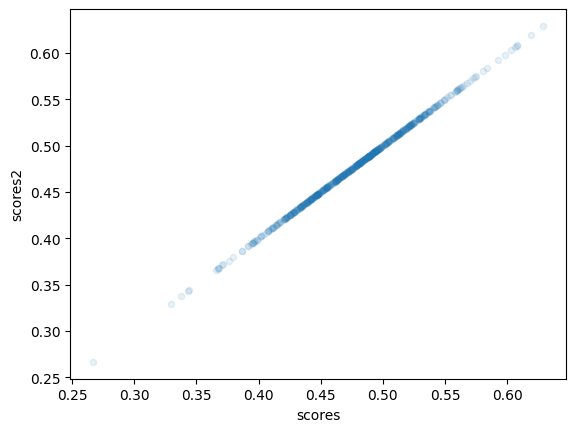

In [90]:
import pandas as pd

df = pd.DataFrame({"fname":dataset._image_fnames, "scores":scores.cpu().numpy(), "scores2":scores.cpu().numpy()})
df.plot.scatter(x="scores", y="scores2", alpha=0.1)
ind= len(df)//2+100
im_path = df.sort_values(by="scores", ascending=False)["fname"].values[ind]
s = df.sort_values(by="scores", ascending=False)["scores"].values[ind]
# load and show
im = Image.open(fake_dir+'/'+im_path)
# add text
from PIL import ImageDraw
draw = ImageDraw.Draw(im)
draw.text((10, 10), f"Score: {s:.2f}", fill="red", size=4000)
im.show()


In [ ]:
import os
import shutil
base = fake_dir
# Sort by "scores" descending and get top 50%
df_sorted_scores = df.sort_values(by="scores", ascending=False)
top_50pct_scores = df_sorted_scores.head(len(df_sorted_scores) // 2)

out_dir_scores = "top50_by_scores"

os.makedirs(base+out_dir_scores, exist_ok=True)

# Copy files for top 50% by "scores"
for fname in top_50pct_scores["fname"]:
    src = base
    # If the file path is not absolute, you may need to prepend the dataset path
    if not os.path.isabs(src):
        src = os.path.join(dataset.path, src)
    if os.path.exists(src):
        shutil.copy(src+f"/{fname}", os.path.join(base+out_dir_scores, os.path.basename(fname)))

# # Sort by "scores2" descending and get top 50%
# df_sorted_scores2 = df.sort_values(by="scores2", ascending=False)
# top_50pct_scores2 = df_sorted_scores2.head(len(df_sorted_scores2) // 5)

# # Sort by "scores2" descending and get top 50%
# df['combined'] = df['scores'] + df['scores2']
# df_sorted_combined = df.sort_values(by="combined", ascending=False)
# top_50pct_combined = df_sorted_combined.head(len(df_sorted_combined) // 5)

# # Output directories
# out_dir_scores2 = "top50_by_scores2"
# out_dir_combined = "top50_by_combined"
# os.makedirs(out_dir_scores2, exist_ok=True)
# os.makedirs(out_dir_combined, exist_ok=True)

# combined
# for fname in top_50pct_combined["fname"]:
#     src = base+fname
#     if not os.path.isabs(src):
#         src = os.path.join(dataset.path, src)
#     if os.path.exists(src):
#         shutil.copy(src, os.path.join(out_dir_combined, os.path.basename(fname)))


# # Copy files for top 50% by "scores2"
# for fname in top_50pct_scores2["fname"]:
#     src = base+fname
#     if not os.path.isabs(src):
#         src = os.path.join(dataset.path, src)
#     if os.path.exists(src):
#         shutil.copy(src, os.path.join(out_dir_scores2, os.path.basename(fname)))

In [ ]:
import pickle
import sys
with open('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/face_utils/scores.pkl', 'rb') as fp:
    scores2 = pickle.load(fp)



len(scores2)

22428

In [55]:
c = '/Users/adamsobieszek/PycharmProjects/_manipy/additional_age_faces_filtered_via_feature_distance/'
for f in os.listdir(c):
    os.rename(c+f"{f}", c+f"{f.replace('.pt.jpg', '.jpg')}")
    # shutil.copy('/Users/adamsobieszek/PycharmProjects/_manipy/deixis/top50_by_combined/'+f"{f}", base+out_dir_scores+f"/{f}")
    # shutil.copy('/Users/adamsobieszek/Downloads/content 2/drive/Shareddrives/[PsychGAN]/age_test_redo_additional/coords/'+f"{f.replace('.jpg', '')}", base+out_dir_scores+f"/{f.replace('.jpg', '')}")

In [ ]:
# ---------- Edge partial-face detection ----------

def _skin_mask_bgr(img_bgr: np.ndarray) -> np.ndarray:
    """Race-agnostic skin mask using YCrCb + HSV union, then cleaned."""
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    # classic YCrCb box (wide)
    m1 = (Cr >= 133) & (Cr <= 180) & (Cb >= 77) & (Cb <= 135) & (Y >= 40)

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    # wide HSV skin zone
    m2 = ((H <= 25) | (H >= 160)) & (S >= 30) & (V >= 40)

    m = (m1 | m2).astype(np.uint8) * 255
    # clean
    m = cv2.medianBlur(m, 5)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  np.ones((3,3), np.uint8))
    return m
# ---------- replace in your code ----------

def _strip_boxes(h: int, w: int, frac: float = 0.18):
    t = max(1, int(round(frac * min(h, w))))  # ensure at least 1 px
    return {
        "left":   (slice(0, h), slice(0, t)),
        "right":  (slice(0, h), slice(w - t, w)),
        "top":    (slice(0, t), slice(0, w)),
        "bottom": (slice(h - t, h), slice(0, w)),
    }

def _eye_cue(gray: np.ndarray, skin_mask: np.ndarray) -> float:
    """Return [0,1] eye-likeliness in a region (dark circle in skin)."""
    # Skip tiny/empty ROIs
    if gray.size == 0 or gray.shape[0] < 8 or gray.shape[1] < 8:
        return 0.0

    # emphasize dark blobs on skin
    g = cv2.GaussianBlur(gray, (0,0), 1.2)
    dog = cv2.Laplacian(g, cv2.CV_32F) * -1.0  # dark-on-light positive
    if skin_mask is not None and skin_mask.size == gray.size:
        dog = np.where(skin_mask.astype(bool), dog, 0.0)

    # HoughCircles needs CV_8UC1
    dog8 = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    dog8 = cv2.equalizeHist(dog8)

    h, w = gray.shape
    rmin = max(2, int(0.01 * min(h, w)))
    rmax = max(rmin + 1, int(0.04 * min(h, w)))

    circles = cv2.HoughCircles(
        dog8, cv2.HOUGH_GRADIENT, dp=1.2,
        minDist=max(4, int(0.08 * min(h, w))),
        param1=80, param2=8,
        minRadius=rmin, maxRadius=rmax
    )
    if circles is None:
        return 0.0
    c = min(3, circles.shape[1])
    return float(min(1.0, c / 2.0))

def _mouth_cue(img_bgr: np.ndarray, skin_mask: np.ndarray) -> float:
    """Return [0,1] mouth-likeliness (reddish elongated blob in skin)."""
    b,g,r = cv2.split(img_bgr.astype(np.int16))
    lipness = np.clip((r - (g+ b)//2), 0, 255).astype(np.uint8)
    lipness[skin_mask == 0] = 0
    lipness = cv2.GaussianBlur(lipness, (0,0), 1.0)
    _, th = cv2.threshold(lipness, 0, 255, cv2.THRESH_OTSU)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    cnts,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best = 0.0
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 25: 
            continue
        x,y,w,h = cv2.boundingRect(c)
        ar = w/(h+1e-6)
        if ar >= 1.4:  # elongated horizontally
            best = max(best, min(1.0, (area / (img_bgr.shape[0]*img_bgr.shape[1]))*80.0))
    return best

def _cheek_arc_cue(skin_mask: np.ndarray, border_side: str) -> float:
    """
    Look for a large skin component touching the border that fits an inward-facing ellipse arc.
    Returns [0,1].
    """
    h,w = skin_mask.shape
    # components
    cnts,_ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best = 0.0
    for c in cnts:
        if len(c) < 10: 
            continue
        area = cv2.contourArea(c)
        if area < 0.003 * h * w:
            continue
        x,y,bw,bh = cv2.boundingRect(c)
        touches = {
            "left":   x <= 1,
            "right":  x + bw >= w-2,
            "top":    y <= 1,
            "bottom": y + bh >= h-2
        }[border_side]
        if not touches:
            continue
        # fit ellipse for curvature check
        if len(c) >= 5:
            (cx, cy), (ma, mi), angle = cv2.fitEllipse(c)
            major = max(ma, mi)
            # center must be inside image and offset inward from that border
            inward = {
                "left":   cx > 0.25*major,
                "right":  (w - cx) > 0.25*major,
                "top":    cy > 0.25*major,
                "bottom": (h - cy) > 0.25*major
            }[border_side]
            if inward:
                # strength grows with area and curvature smoothness
                perim = cv2.arcLength(c, True) + 1e-6
                smooth = min(1.0, (area/perim) / 4.0)  # crude convex smoothness
                score = min(1.0, (area/(h*w))*150.0) * 0.6 + 0.4*smooth
                best = max(best, score)
    return best


def detect_partial_face_edges(img_bgr: np.ndarray, main_bbox: Optional[np.ndarray]=None,
                              debug: bool=False) -> Tuple[bool, dict]:
    """
    Return (has_partial_face, details_dict).
    Heavily biased toward catching *any* face fragment touching the image border,
    while trying to ignore neck/shoulder skin.
    """
    h, w = img_bgr.shape[:2]
    # Optionally blank out the central main face bbox so it's not counted as 'edge'
    mask_exclude = np.zeros((h,w), np.uint8)
    if main_bbox is not None:
        x1,y1,x2,y2 = np.array(main_bbox, int)
        cv2.rectangle(mask_exclude, (x1,y1), (x2,y2), 255, -1)

    strips = _strip_boxes(h, w, frac=0.18)
    skin = _skin_mask_bgr(img_bgr)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    details = {}
    fired_any = False
    for side, (ys, xs) in strips.items():
        roi_skin = skin[ys, xs].copy()
        roi_skin[mask_exclude[ys, xs] > 0] = 0  # exclude main face region if provided
        if roi_skin.sum() < 100:  # almost no skin on this edge
            details[side] = {"skin_frac": 0.0, "eye": 0.0, "mouth": 0.0, "cheek": 0.0, "score": 0.0}
            continue

        roi_bgr = img_bgr[ys, xs]
        roi_gray = gray[ys, xs]

        skin_frac = float(roi_skin.mean()/255.0)

        eye_s   = _eye_cue(roi_gray, roi_skin)
        mouth_s = _mouth_cue(roi_bgr, roi_skin)
        cheek_s = _cheek_arc_cue(roi_skin, side)

        # Combine: require skin + (eye OR mouth OR cheek_arc)
        score = (0.4*eye_s + 0.3*mouth_s + 0.3*cheek_s) * (0.5 + 0.5*skin_frac)

        # Heavy-handed thresholds:
        # - fire if strong cue OR moderate cue with lots of skin on the edge
        fire = (score >= 0.35) or (skin_frac >= 0.25 and (eye_s >= 0.25 or mouth_s >= 0.25 or cheek_s >= 0.25))

        details[side] = {
            "skin_frac": skin_frac,
            "eye": eye_s,
            "mouth": mouth_s,
            "cheek": cheek_s,
            "score": score,
            "fire": bool(fire)
        }
        fired_any |= fire

    if debug:
        print(details)
    return fired_any, details



In [ ]:
from __future__ import annotations
from typing import Any, Callable, Dict, List, Mapping, Tuple, Optional
import numpy as np
import cv2

# type for metric functions: receive a read-only context, return either a float
# or a (name, value) pair. If only a float is returned, the metric's __name__ is used.
MetricFn = Callable[[Mapping[str, Any]], float | Tuple[str, float]]
# ---- helpers ----
def _coalesce_ndarray(*vals):
    """
    Return the first value that is not None and, if ndarray-like, has size > 0.
    """
    for v in vals:
        if v is None:
            continue
        if isinstance(v, np.ndarray):
            if v.size == 0:
                continue
        return v
    return None

# ---- replace your _build_metric_context with this version ----
def _build_metric_context(vision_frame: VisionFrame) -> Dict[str, Any]:
    ctx: Dict[str, Any] = {}
    h, w = vision_frame.shape[:2]
    ctx["vision_frame"] = vision_frame
    ctx["H"], ctx["W"] = h, w

    faces = get_many_faces([vision_frame])
    ctx["faces"] = faces
    ctx["num_faces"] = len(faces)

    if not faces:
        ctx.update({
            "face": None, "bbox": None, "bbox_w": None,
            "lmk68": None, "lmk5": None,
            "crop": None, "gray": None,
            "full_gray": cv2.cvtColor(vision_frame, cv2.COLOR_BGR2GRAY),
            "det_raw": None, "emb_norm": None
        })
        return ctx

    face: Face = max(faces, key=lambda f: f.score_set.get('detector', 0.0))
    x1, y1, x2, y2 = face.bounding_box
    bbox = np.array([x1, y1, x2, y2], dtype=float)
    bbox_w = max(1.0, x2 - x1)

    lmk68 = face.landmark_set.get('68')
    # SAFE coalesce instead of "or"
    lmk5  = _coalesce_ndarray(face.landmark_set.get('5/68'),
                              face.landmark_set.get('5'))

    crop = _crop_from_bbox(vision_frame, bbox)
    if crop.size == 0:
        crop = vision_frame
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    full_gray = cv2.cvtColor(vision_frame, cv2.COLOR_BGR2GRAY)

    ctx.update({
        "face": face,
        "bbox": bbox,
        "bbox_w": bbox_w,
        "lmk68": lmk68,
        "lmk5":  lmk5,
        "crop": crop,
        "gray": gray,
        "full_gray": full_gray,
        "det_raw": float(face.score_set.get('detector', 0.0)),
        "emb_norm": getattr(face, "embedding_norm", None),
    })
    return ctx

def evaluate_metrics(
    vision_frame: VisionFrame,
    metric_fns: List[MetricFn],
    *,
    include_meta: bool = True
) -> Dict[str, float]:
    """
    Run a list of metric functions on a single image.
    Each metric_fn(ctx) may return either a float or ('name', float).
    Returns {name: value}. Adds a few useful meta entries when include_meta=True.
    """
    ctx = _build_metric_context(vision_frame)
    out: Dict[str, float] = {}

    # Optional meta so you can filter in tests
    if include_meta:
        out["meta_num_faces"] = float(ctx["num_faces"])
        out["meta_has_faces"] = 1.0 if ctx["num_faces"] > 0 else 0.0

    for fn in metric_fns:
        name = getattr(fn, "__name__", "metric")
        val = fn(ctx)
        if isinstance(val, tuple) and len(val) == 2:
            name, score = val  # ('custom_name', value)
        else:
            score = float(val)  # use fn.__name__ as key
        out[name] = float(score)
        # keep testing even if a metric fails
    return out

def m_det(ctx):  # detector confidence → [0,1]
    det_raw = ctx["det_raw"]
    return ("det", _scale01(det_raw, DET_SCORE_MIN, DET_SCORE_MAX)) if det_raw is not None else ("det", 0.0)

def m_geom(ctx):
    l68, bw = ctx["lmk68"], ctx["bbox_w"]
    return ("geom", _geom_symmetry_score(l68, bw) if _has_68(l68) else 0.7)

def m_pose(ctx):
    l68, l5 = ctx["lmk68"], ctx["lmk5"]
    if _has_68(l68):
        yaw, pitch, roll = _estimate_pose_from_68(l68)
    elif l5 is not None:
        yaw, pitch, roll = _pose_from_5(l5)
    else:
        return ("pose", 0.5)
    yaw_p = _clamp01(1.0 - abs(yaw)/POSE_MAX_YAW)
    pit_p = _clamp01(1.0 - abs(pitch)/POSE_MAX_PITCH)
    rol_p = _clamp01(1.0 - abs(roll)/POSE_MAX_ROLL)
    return ("pose", 0.4*yaw_p + 0.3*pit_p + 0.3*rol_p)

def m_sharp(ctx):
    if ctx["gray"] is None: return ("sharp", 0.0)
    lapv = _laplacian_var(ctx["gray"])
    return ("sharp", _clamp01((lapv - LAPLACIAN_BAD) / (LAPLACIAN_GOOD - LAPLACIAN_BAD)))

def m_exposure(ctx):
    if ctx["gray"] is None: return ("exposure", 0.0)
    g = ctx["gray"]; mean, std = float(g.mean()), float(g.std())
    if mean < EXPO_LOW: band = _scale01(mean, 0.0, EXPO_LOW)
    elif mean > EXPO_HIGH: band = _scale01(255.0 - mean, 0.0, 255.0-EXPO_HIGH)
    else: band = 1.0
    spread = _scale01(std, EXPO_STD_MIN, 90.0)
    return ("exposure", 0.7*band + 0.3*spread)

def m_center(ctx):
    if ctx["bbox"] is None: return ("center", 0.0)
    return ("center", _centering_score(ctx["bbox"], ctx["W"], ctx["H"]))

def m_occl(ctx):
    if not _has_68(ctx["lmk68"]): return ("occl", 0.5)
    return ("occl", _occlusion_score(ctx["full_gray"], ctx["lmk68"], ctx["bbox"]))
# === Edge-partial metrics (uses detect_partial_face_edges) ===

def _edge_info(ctx):
    """
    Compute (or reuse cached) edge-partial result for this image.
    Returns (has_partial: bool, details: dict).
    """
    key = "_edge_info_cached"
    if key in ctx:
        return ctx[key]
    bbox = ctx.get("bbox")
    main_bbox = None if bbox is None else np.array(bbox, dtype=int)
    has_partial, details = detect_partial_face_edges(
        ctx["vision_frame"], main_bbox=main_bbox, debug=False
    )
    ctx[key] = (has_partial, details)  # cache for sibling metrics
    return ctx[key]

def m_edge_partial(ctx):
    has, _ = _edge_info(ctx)
    return ("edge_partial", 1.0 if has else 0.0)

def make_edge_fire(side: str):
    def _m(ctx):
        _, det = _edge_info(ctx)
        d = det.get(side, {})
        return (f"edge_{side}_fire", 1.0 if d.get("fire", False) else 0.0)
    _m.__name__ = f"m_edge_{side}_fire"
    return _m

def make_edge_score(side: str):
    def _m(ctx):
        _, det = _edge_info(ctx)
        d = det.get(side, {})
        return (f"edge_{side}_score", float(d.get("score", 0.0)))
    _m.__name__ = f"m_edge_{side}_score"
    return _m

def make_edge_skin_frac(side: str):
    def _m(ctx):
        _, det = _edge_info(ctx)
        d = det.get(side, {})
        return (f"edge_{side}_skin_frac", float(d.get("skin_frac", 0.0)))
    _m.__name__ = f"m_edge_{side}_skin"
    return _m

In [ ]:
import numpy as np
import cv2

# if you already defined these earlier, keep your versions:
def _strip_boxes(h: int, w: int, frac: float = 0.18):
    t = max(1, int(round(frac * min(h, w))))
    # widen at very low resolutions
    if max(h, w) <= 256:
        t = max(t, int(0.25 * min(h, w)))
    return {
        "left":   (slice(0, h), slice(0, t)),
        "right":  (slice(0, h), slice(w - t, w)),
        "top":    (slice(0, t), slice(0, w)),
        "bottom": (slice(h - t, h), slice(0, w)),
    }

def _skin_mask_bgr(img_bgr: np.ndarray) -> np.ndarray:
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    m1 = (Cr >= 133) & (Cr <= 180) & (Cb >= 77) & (Cb <= 135) & (Y >= 40)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    m2 = ((H <= 25) | (H >= 160)) & (S >= 30) & (V >= 40)
    m = (m1 | m2).astype(np.uint8) * 255
    m = cv2.medianBlur(m, 5)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  np.ones((3,3), np.uint8))
    return m

def _bbox_iou(a, b) -> float:
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    area_a = max(0, ax2-ax1) * max(0, ay2-ay1)
    area_b = max(0, bx2-bx1) * max(0, by2-by1)
    union = area_a + area_b - inter + 1e-6
    return inter / union

def detect_similar_skin_blob_outside_bbox(
    img_bgr: np.ndarray,
    main_bbox: np.ndarray,
    *,
    border_frac: float = 0.18,
    chi2_thresh: float = 9.0,           # ~99% for 2D Gaussian (Cr,Cb)
    min_area_frac: float = 0.0015,      # of full image; auto clamps below
    exclude_neck: bool = True
) -> tuple[bool, dict]:
    """
    Detects border-touching blobs outside main_bbox whose chroma (Cr,Cb) matches
    the main face's skin statistics. Returns (has_blob, details).
    """
    h, w = img_bgr.shape[:2]
    x1, y1, x2, y2 = np.array(main_bbox, int)
    x1 = np.clip(x1, 0, w-1); x2 = np.clip(x2, 0, w-1)
    y1 = np.clip(y1, 0, h-1); y2 = np.clip(y2, 0, h-1)

    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)

    # Skin mask inside main face (fallback to whole box if empty)
    main_skin = _skin_mask_bgr(img_bgr)[y1:y2, x1:x2]
    sel = main_skin > 0
    Cr_box = Cr[y1:y2, x1:x2][sel]
    Cb_box = Cb[y1:y2, x1:x2][sel]
    if Cr_box.size < 50:
        Cr_box = Cr[y1:y2, x1:x2].ravel()
        Cb_box = Cb[y1:y2, x1:x2].ravel()

    # robust chroma center & scale (median + MAD)
    mu = np.array([np.median(Cr_box), np.median(Cb_box)], dtype=np.float32)
    mad = 1.4826 * np.array([
        np.median(np.abs(Cr_box - mu[0])) + 1e-6,
        np.median(np.abs(Cb_box - mu[1])) + 1e-6
    ], dtype=np.float32)
    inv_var = 1.0 / (mad ** 2)

    # Mahalanobis distance (diag) for all pixels
    dcr = (Cr.astype(np.float32) - mu[0]) ** 2 * inv_var[0]
    dcb = (Cb.astype(np.float32) - mu[1]) ** 2 * inv_var[1]
    d2  = dcr + dcb

    # Candidate mask: similar chroma & skin-like & outside main bbox
    sim = (d2 < chi2_thresh).astype(np.uint8) * 255
    skin = _skin_mask_bgr(img_bgr)
    cand = cv2.bitwise_and(sim, skin)

    # Blank a slightly shrunken version of main bbox so neighbors remain
    shrink_x = int(0.08 * (x2 - x1))
    shrink_y = int(0.08 * (y2 - y1))
    ex1 = max(0, x1 + shrink_x); ex2 = min(w-1, x2 - shrink_x)
    ey1 = max(0, y1 + shrink_y); ey2 = min(h-1, y2 - shrink_y)
    cand[ey1:ey2, ex1:ex2] = 0

    # Keep only border strips
    strips = _strip_boxes(h, w, border_frac)
    mask_border = np.zeros((h, w), np.uint8)
    for s in strips.values():
        mask_border[s] = 255
    cand = cv2.bitwise_and(cand, mask_border)

    # Clean and find components
    cand = cv2.morphologyEx(cand, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    cand = cv2.morphologyEx(cand, cv2.MORPH_OPEN,  np.ones((3,3), np.uint8))

    min_area = max(40, int(min_area_frac * h * w))
    cnts, _ = cv2.findContours(cand, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    details = {"blobs": []}
    fired = False
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area:
            continue
        x, y, bw, bh = cv2.boundingRect(c)

        # which side?
        touches_left   = x <= 1
        touches_right  = x + bw >= w - 2
        touches_top    = y <= 1
        touches_bottom = y + bh >= h - 2
        side = None
        if touches_left:   side = "left"
        if touches_right:  side = "right" if side is None else side + "+right"
        if touches_top:    side = "top" if side is None else side + "+top"
        if touches_bottom: side = "bottom" if side is None else side + "+bottom"

        # optional: ignore neck (tall, below face, overlaps horizontally with face)
        if exclude_neck:
            overlap_x = not (x2 < x or x + bw < x1)  # horizontal overlap with face
            is_below  = y > y2 - int(0.05 * (y2 - y1))
            tall      = bh / (bw + 1e-6) > 1.5
            if overlap_x and is_below and tall:
                continue

        # average chroma distance inside blob (stronger means more face-like)
        mask = np.zeros((h, w), np.uint8)
        cv2.drawContours(mask, [c], -1, 255, -1)
        mean_d2 = float(np.mean(d2[mask > 0])) 
        sim_score = float(np.clip(1.0 - (mean_d2 / (chi2_thresh + 1e-6)), 0.0, 1.0))

        details["blobs"].append({
            "bbox": [int(x), int(y), int(x + bw), int(y + bh)],
            "area": float(area),
            "side": side or "unknown",
            "mean_chi2": mean_d2,
            "similarity": sim_score
        })

        # Fire if it's a confident, sizable, border-touching blob
        if sim_score >= 0.35:
            fired = True

    details["fired"] = fired
    return fired, details
def _edge_color_info(ctx):
    key = "_edge_color_cached"
    if key in ctx:
        return ctx[key]
    bbox = ctx.get("bbox")
    if bbox is None:
        ctx[key] = (False, {"blobs": [], "fired": False})
    else:
        has, info = detect_similar_skin_blob_outside_bbox(ctx["vision_frame"], np.array(bbox, int))
        ctx[key] = (has, info)
    return ctx[key]

def m_edge_color_partial(ctx):
    has, _ = _edge_color_info(ctx)
    return ("edge_color_partial", 1.0 if has else 0.0)

def m_edge_color_max_sim(ctx):
    _, info = _edge_color_info(ctx)
    mx = max((b.get("similarity", 0.0) for b in info.get("blobs", [])), default=0.0)
    return ("edge_color_max_sim", float(mx))

In [ ]:
# Minimal interactive/notebook-friendly POC for age-preserving traversal toward w_avg in W-space.
# Robust to environments without ipywidgets: if ipywidgets is unavailable,
# the code still defines all functions and provides a callable `run_static_demo(...)`.
#
# Assumptions in *your* notebook runtime (not this sandbox):
# - Variables `age_model`, `w_avg`, `G`, and `ws` are defined.
# - `G.synthesis(ws, noise_mode="const")` returns images in [-1, 1].
# - `ws[:4]` gives four starting latent codes. They may be shaped [4, D] or [4, num_ws, D].


final_models_path = "/Users/adamsobieszek/PycharmProjects/psychGAN/content/"
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Helpers
# ------------------------------

def _infer_device():
    """Prefer the device of w_avg; else fall back to G's device; else cpu."""
    dev = None
    if isinstance(globals().get("w_avg", None), torch.Tensor):
        dev = w_avg.device
    if dev is None and "G" in globals():
        try:
            dev = next(G.parameters()).device
        except Exception:
            dev = torch.device("cpu")
    if dev is None:
        dev = torch.device("cpu")
    return dev

def _normalize_ws_shape(ws_in: torch.Tensor):
    """
    Normalize various W shapes to:
      - w_single: (B, D) tensor to optimize
      - expand_for_gen: callable to expand (B,D) -> (B, num_ws, D) for synthesis
      - num_ws inferred from G or default 18.
    """
    assert isinstance(ws_in, torch.Tensor), "Expected `ws` to be a torch.Tensor"
    # If ws_in is (B, D): treat as single W to be broadcast across layers.
    # If ws_in is (B, num_ws, D): take the first as the single W for optimization (common trick).
    if ws_in.ndim == 2:
        w_single = ws_in
    elif ws_in.ndim == 3 and ws_in.shape[1] >= 1:
        w_single = ws_in[:, 0, :]
    else:
        raise ValueError("Unsupported ws shape. Expected (B,D) or (B,num_ws,D).")
    # Infer num_ws from G if possible
    num_ws = int(getattr(getattr(globals().get("G", object), "synthesis", object), "num_ws", 18))
    def expand_for_gen(w_bxd: torch.Tensor):
        return w_bxd.unsqueeze(1).repeat(1, num_ws, 1)
    return w_single, expand_for_gen, num_ws

@torch.no_grad()
def _synthesize_images(G, w_bxd: torch.Tensor, expand_for_gen, to_uint8=True):
    """
    Synthesizes a batch of images from a batch of (B, D) W vectors by repeating across layers.
    Returns float [0,1] if to_uint8=False, else uint8 (B, H, W, C).
    """
    ws_bxLxd = expand_for_gen(w_bxd)
    try:
        imgs = G.synthesis(ws_bxLxd, noise_mode="const")
    except TypeError:
        imgs = G.synthesis(ws_bxLxd)
    imgs = torch.clamp((imgs + 1.0) * 0.5, 0.0, 1.0)  # [-1,1] -> [0,1]
    if to_uint8:
        imgs8 = (imgs.detach().cpu() * 255.0).round().to(torch.uint8)  # (B,C,H,W)
        imgs8 = imgs8.permute(0, 2, 3, 1).contiguous()                # (B,H,W,C)
        return imgs8
    return imgs  # (B,3,H,W) float in [0,1]

def _ensure_vector_wavg(w_avg_tensor: torch.Tensor, D: int) -> torch.Tensor:
    """
    Ensure w_avg is a (D,) vector. If it's (num_ws, D) or (1, D), reduce to (D,).
    """
    if w_avg_tensor.ndim == 1:
        return w_avg_tensor
    if w_avg_tensor.ndim == 2:
        return w_avg_tensor.mean(dim=0)
    raise ValueError("Unsupported w_avg shape; expected (D,) or (num_ws,D).")

# ------------------------------
# Core optimization (POC)
# ------------------------------

def optimize_towards_wavg_with_age_penalty(
    ws_init: torch.Tensor,
    w_avg_vec: torch.Tensor,
    age_model,  # generic callable nn.Module
    steps: int = 100,
    step_size: float = 0.05,
    age_weight: float = 10.0,
    noise_scale: float = 0.0,
    stride: int = 5,
    rng_seed: int = 0,
    device=None,
):
    """
    Perform a simple optimization in W-space:
      minimize  L = ||w - w_avg||^2 + age_weight * (age(w) - age_0)^2
    Using plain gradient descent on w (parameters of age_model are frozen).

    Returns:
      snapshots: list of 5 tensors, each (B,D), representing progress along the path.
      history: dict with scalars for debugging (loss, age drift, dist to w_avg).
    """
    torch.manual_seed(int(rng_seed))
    device = device if device is not None else _infer_device()
    device = torch.device(device)

    ws = ws_init.to(device).detach().clone()
    B, D = ws.shape
    w_avg_vec = _ensure_vector_wavg(w_avg_vec.to(device), D)

    # Freeze age_model params (if any) while keeping autograd for inputs
    try:
        if isinstance(age_model, nn.Module):
            age_model.eval()
            for p in age_model.parameters():
                p.requires_grad_(False)
    except Exception:
        pass

    with torch.no_grad():
        age0 = age_model(ws).view(B)

    snapshots = [ws.detach().clone()]
    loss_hist, age_drift_hist, dist_hist = [], [], []

    # Ensure enough steps for 5 checkpoints
    min_steps = max(1, 4 * stride)
    steps = max(int(steps), min_steps)

    for t in range(1, steps + 1):
        ws = ws.detach().requires_grad_(True)
        pred_age = age_model(ws).view(B)

        dist_term = ((ws - w_avg_vec.unsqueeze(0)) ** 2).mean()
        age_pen   = ((pred_age - age0) ** 2).mean()
        loss = dist_term + age_weight * age_pen

        loss.backward()
        with torch.no_grad():
            grad = ws.grad
            step = -step_size * grad
            if noise_scale > 0.0:
                step = step + noise_scale * torch.randn_like(ws)
            ws = (ws + step).detach()

        # Logs
        loss_hist.append(float(loss.detach().cpu()))
        with torch.no_grad():
            age_drift = float(((pred_age - age0) ** 2).mean().sqrt().detach().cpu())
            wdist = float(((ws - w_avg_vec.unsqueeze(0)) ** 2).mean().sqrt().detach().cpu())
            age_drift_hist.append(age_drift)
            dist_hist.append(wdist)

        # Save up to 5 snapshots at multiples of `stride`
        if (t % stride == 0) and (len(snapshots) < 5):
            snapshots.append(ws.detach().clone())
        if len(snapshots) >= 5:
            break

    history = {
        "loss": np.array(loss_hist, dtype=np.float32),
        "age_drift_rmse": np.array(age_drift_hist, dtype=np.float32),
        "w_dist_rmse": np.array(dist_hist, dtype=np.float32),
    }
    return snapshots, history

# ------------------------------
# Visualization
# ------------------------------

def _render_grid(images_by_col, title_by_col=None):
    """
    images_by_col: list of length 5; each element is a (B,H,W,C) uint8 batch to show in a column.
    """
    cols = len(images_by_col)
    assert cols == 5, "Expecting exactly 5 progress columns."
    B = images_by_col[0].shape[0]
    fig, axes = plt.subplots(B, cols, figsize=(2.8*cols, 2.8*B))
    if B == 1:
        axes = np.expand_dims(axes, 0)
    if cols == 1:
        axes = np.expand_dims(axes, -1)

    for c in range(cols):
        imgs = images_by_col[c]
        for r in range(B):
            ax = axes[r, c]
            ax.imshow(imgs[r].numpy())
            ax.axis("off")
            if title_by_col is not None and r == 0:
                ax.set_title(title_by_col[c], fontsize=10)
    plt.tight_layout()
    plt.show()

def _run_demo(stride=5, steps=80, step_size=0.05, noise_scale=0.01, age_weight=10.0, rng_seed=0):
    global G, ws, age_model, w_avg, names, codes
    device = _infer_device()
    assert "ws" in globals(), "Expected a global variable `ws` with latent codes."
    assert "G" in globals(),  "Expected a global variable `G` (generator)."
    assert "age_model" in globals(), "Expected a global variable `age_model`."
    assert "w_avg" in globals(), "Expected a global variable `w_avg`."

    ws4 = ws[:4]
    w_single, expand_for_gen, num_ws = _normalize_ws_shape(ws4)

    # Prepare w_avg vector
    D = w_single.shape[1]
    wav = _ensure_vector_wavg(w_avg, D)

    # Optimize with snapshots
    snaps, hist = optimize_towards_wavg_with_age_penalty(
        w_single, wav, age_model,
        steps=int(steps),
        step_size=float(step_size),
        age_weight=float(age_weight),
        noise_scale=float(noise_scale),
        stride=int(stride),
        rng_seed=int(rng_seed),
        device=device
    )

    # Synthesize 5 columns (each column is a batch of 4 images)
    cols = []
    for i, wcol in enumerate(snaps):
        imgs = _synthesize_images(G, wcol.to(device), expand_for_gen, to_uint8=True)  # (B,H,W,C) uint8
        cols.append(imgs)

    titles = [f"step {i*stride}" for i in range(5)]
    _render_grid(cols, titles)

    print(f"Final loss: {hist['loss'][-1]:.4f} | Age drift RMSE: {hist['age_drift_rmse'][-1]:.4f} | W-dist RMSE: {hist['w_dist_rmse'][-1]:.4f}")

%cd /Users/adamsobieszek/PycharmProjects/_manipy/


from manipy.models.flow_models import VectorFieldTransformer, RatingODE
from manipy.models.layers import EnsembleRegressor, MeanRegressor
from manipy.models.rating_models import AlphaBetaRegressor

coord_path = '/Users/adamsobieszek/Downloads/content 2/drive/Shareddrives/[PsychGAN]/age_test_redo_additional/coords/'
cpath = '/Users/adamsobieszek/Downloads/content 2/drive/Shareddrives/[PsychGAN]/age_test_redo_additional/coords'
c = []
device = 'mps'

del control_models
if not "control_models" in dir():
  # if not os.path.exists("final_models.zip"):
  #   !gdown 1pPjOd-mx-d-vOw1QR_lpJoJmLAGdkI3W
  #   !unzip final_models.zip
  #   !unzip final_models.zip
  control_names = ['trustworthy','dominant', 'gender', 'age', 'white', 'happy']
  control_models = [EnsembleRegressor([MeanRegressor(512,1) for _ in range(8)], model_kwargs={}).to(device) for label in control_names]
  for m,l in zip(control_models,control_names):
    m.load_state_dict(torch.load(f"{final_models_path}/final_models/ensemble_{l}.pt", map_location=torch.device("mps")))
    m.eval()
  ALL_MODELS = {**{l:(m) for l,m in zip(control_names,control_models)}}
  

age_model = ALL_MODELS['age']
names = []
for f in os.listdir(cpath):
    try:
        c.append(torch.load(cpath+"/"+f, map_location='cpu')['w'])
        names.append(f)
    except Exception as e:
        print(f"Error loading {f}: {e}")
        print(e)
ws = torch.stack(c).to(device)
codes = ws
w_avg = G.mapping.w_avg.to(device)
_widgets_available = False
try:
    import ipywidgets as widgets
    _widgets_available = True
except ModuleNotFoundError:
    _widgets_available = False

if _widgets_available:
    stride_slider     = widgets.IntSlider(description="Stride", min=1, max=50, step=1, value=5, continuous_update=False)
    steps_slider      = widgets.IntSlider(description="Steps", min=20, max=400, step=5, value=80, continuous_update=False)
    step_size_slider  = widgets.FloatSlider(description="Step size", min=0.001, max=0.2, step=0.001, value=0.05, readout_format=".3f", continuous_update=False)
    noise_slider      = widgets.FloatSlider(description="Noise scale", min=0.0, max=0.1, step=0.001, value=0.01, readout_format=".3f", continuous_update=False)
    age_w_slider      = widgets.FloatSlider(description="Age weight", min=0.0, max=100.0, step=0.5, value=10.0, readout_format=".1f", continuous_update=False)
    seed_box          = widgets.IntText(description="Seed", value=0)

    controls = widgets.VBox([
        widgets.HTML("<h3>Age-preserving W traversal toward w_avg</h3>"),
        widgets.HBox([stride_slider, steps_slider, step_size_slider]),
        widgets.HBox([noise_slider, age_w_slider, seed_box])
    ])

    out = widgets.interactive_output(
        _run_demo,
        {
            "stride": stride_slider,
            "steps": steps_slider,
            "step_size": step_size_slider,
            "noise_scale": noise_slider,
            "age_weight": age_w_slider,
            "rng_seed": seed_box
        }
    )

    display(controls, out)
else:
    print(
        "ipywidgets is not installed in this environment.\n"
        "All functions have been defined. In your own notebook with `G`, `ws`, `age_model`, and `w_avg` available,\n"
        "either install ipywidgets for the interactive UI, or call this directly:\n\n"
        "  _run_demo(stride=5, steps=80, step_size=0.05, noise_scale=0.01, age_weight=10.0, rng_seed=0)\n\n"
        "Nothing was executed because required globals are not present in this sandbox."
    )

/Users/adamsobieszek/PycharmProjects/_manipy


NameError: name 'control_models' is not defined

In [ ]:
import os, shutil, tempfile
import torch
import torch.nn as nn

def _restore_original_shape(w_single_1xd: torch.Tensor, original_w: torch.Tensor) -> torch.Tensor:
    """
    Take an optimized single-W tensor of shape (1, D) and broadcast it back to the
    original shape of `original_w` (either (D,) or (num_ws, D)).
    """
    D = w_single_1xd.shape[-1]
    if original_w.ndim == 1:
        # (D,)
        return w_single_1xd.squeeze(0)
    elif original_w.ndim == 2:
        # (num_ws, D)
        num_ws = original_w.shape[0]
        return w_single_1xd.repeat(num_ws, 1)
    else:
        raise ValueError(f"Unsupported original 'w' shape {tuple(original_w.shape)}; expected (D,) or (num_ws, D).")

def optimize_latents_in_directory(
    cpath: str,
    *,
    age_model,
    G,  
    w_avg: torch.Tensor,
    steps: int = 120,
    step_size: float = 0.03,
    age_weight: float = 8.0,
    noise_scale: float = 0.0,
    stride: int = 10,
    rng_seed: int = 0,
    key: str = "w",
    overwrite: bool = True,
    make_backup: bool = True,
    backup_ext: str = ".bak",
    device=None,
):
    """
    For each .pt/.pth in `cpath`, load dict, read `dict[key]` (a W vector of shape (D,) or (num_ws, D)),
    run age-preserving optimization toward w_avg, and write the updated dict back.

    Returns:
        summary dict with 'updated' and 'failed' lists.
    """
    assert os.path.isdir(cpath), f"Not a directory: {cpath}"
    device = device if device is not None else _infer_device()

    # If age_model is a torch Module, move it to the right device once.
    if isinstance(age_model, nn.Module):
        age_model = age_model.to(device)

    files = sorted(
        f for f in os.listdir(cpath)
        if f.endswith(".pt") or f.endswith(".pth")
    )

    updated, failed = [], []
    for idx, fname in enumerate(files):
        fpath = os.path.join(cpath, fname)
        try:
            obj = torch.load(fpath, map_location="cpu")
            if not isinstance(obj, dict) or key not in obj:
                raise KeyError(f"File does not contain dict['{key}'].")

            original_w = torch.as_tensor(obj[key])  # keep original dtype & shape
            D = int(original_w.shape[-1])

            # Pick a single W to optimize (as in your POC: first layer if (num_ws, D))
            if original_w.ndim == 1:
                w0_1xd = original_w.unsqueeze(0)
            elif original_w.ndim == 2:
                w0_1xd = original_w[:1, :]           # take the first W
            else:
                raise ValueError(f"Unsupported 'w' shape {tuple(original_w.shape)}; expected (D,) or (num_ws, D).")

            # Prepare vectors on device/dtype
            w0_1xd = w0_1xd.to(device=device, dtype=w_avg.dtype)
            w_avg_vec = _ensure_vector_wavg(w_avg.to(device), D)

            # Run the optimization
            snapshots, history = optimize_towards_wavg_with_age_penalty(
                ws_init=w0_1xd,
                w_avg_vec=w_avg_vec,
                age_model=age_model,
                steps=steps,
                step_size=step_size,
                age_weight=age_weight,
                noise_scale=noise_scale,
                stride=stride,
                rng_seed=rng_seed + idx,
                device=device,
            )
            w_opt_1xd = snapshots[-1]              # (1, D) on device
            w_opt_1xd = w_opt_1xd.to(dtype=original_w.dtype)

            # Restore original shape (D,) or (num_ws, D) and move to CPU for saving
            w_opt_shaped = _restore_original_shape(w_opt_1xd, original_w).cpu()
            obj[key] = w_opt_shaped

            # Optional backup
            if make_backup:
                shutil.copy2(fpath, fpath + backup_ext)

            # Atomic-ish write: save to temp then replace
            if overwrite:
                with tempfile.NamedTemporaryFile(dir=cpath, delete=False) as tmp:
                    tmp_path = tmp.name
                try:
                    torch.save(obj, tmp_path)
                    os.replace(tmp_path, fpath)
                finally:
                    if os.path.exists(tmp_path):
                        os.remove(tmp_path)
            else:
                out_path = fpath.replace(".pt", "_opt.pt").replace(".pth", "_opt.pth")
                torch.save(obj, out_path)

            updated.append(fname)

        except Exception as e:
            failed.append((fname, str(e)))

    return {"updated": updated, "failed": failed}

# ------------------------------
# Example usage (with your variables already defined):
# ------------------------------
age_model = ALL_MODELS['age']
device = _infer_device()
summary = optimize_latents_in_directory(
    cpath,
    age_model=age_model,
    G=G,
    w_avg=G.mapping.w_avg,
    steps=120,
    step_size=0.03,
    age_weight=1.0,
    noise_scale=0.0,
    stride=10,
    overwrite=True
)
print("Updated:", summary["updated"])
print("Failed:", summary["failed"])

NameError: name 'ALL_MODELS' is not defined

In [ ]:
# 3) Run your pipeline
from quality_metrics import _crop_from_bbox, _scale01, _has_68, _geom_symmetry_score, _estimate_pose_from_68, _clamp01, _laplacian_var, _centering_score, _occlusion_score
import os
import shutil


target_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/content/out_filtered5"
out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/content/out_filtered6"
os.makedirs(out_dir, exist_ok=True)
passed =[]
Dp = []
for im in os.listdir(target_dir):
    if im.endswith(".pt") or im.startswith("."):
        continue

    metrics = [
    # new edge-partial metrics
    m_edge_partial,
    make_edge_fire("left"), make_edge_fire("right"),
    make_edge_fire("top"),  make_edge_fire("bottom"),
      m_edge_color_partial, m_edge_color_max_sim 
    # (optional debug)
    # make_edge_score("left"), make_edge_skin_frac("left"), ...
]

    vf = visionframe_from_pil(Image.open(f"{target_dir}/{im}"))
    values = evaluate_metrics(vf, metrics)
    print(values)

    # # Example hard reject logic:
    # if values.get("edge_partial", 0.0) >= 0.5:
    #     print("HARD REJECT: partial face at image edge")
    #     print(im)
    #     metrics = [m_det, m_geom, m_pose, m_sharp, m_exposure, m_center, m_occl,     m_edge_color_partial, m_edge_color_max_sim ] # new color-similarity check]x
    #     values = evaluate_metrics(vf, metrics)
    #     # values -> {'meta_num_faces': 1.0, 'meta_has_faces': 1.0, 'det': 0.83, ...}
    #     print(values)
    # else:
    #     # Load the .webp image and save as .jpg in out_dir
    #     from PIL import Image
    #     in_path = f"{target_dir}/{im}"
    #     out_path = f"{out_dir}/{os.path.splitext(im)[0]}.jpg"
    #     img = Image.open(in_path).convert("RGB")
    #     img.save(out_path, "JPEG", quality=95)

{'meta_num_faces': 1.0, 'meta_has_faces': 1.0, 'edge_partial': 0.0, 'edge_left_fire': 0.0, 'edge_right_fire': 0.0, 'edge_top_fire': 0.0, 'edge_bottom_fire': 0.0, 'edge_color_partial': 1.0, 'edge_color_max_sim': 0.87662267731248}
{'meta_num_faces': 1.0, 'meta_has_faces': 1.0, 'edge_partial': 0.0, 'edge_left_fire': 0.0, 'edge_right_fire': 0.0, 'edge_top_fire': 0.0, 'edge_bottom_fire': 0.0, 'edge_color_partial': 1.0, 'edge_color_max_sim': 0.8290139891615791}
{'meta_num_faces': 1.0, 'meta_has_faces': 1.0, 'edge_partial': 0.0, 'edge_left_fire': 0.0, 'edge_right_fire': 0.0, 'edge_top_fire': 0.0, 'edge_bottom_fire': 0.0, 'edge_color_partial': 1.0, 'edge_color_max_sim': 0.7313054701218749}
{'meta_num_faces': 1.0, 'meta_has_faces': 1.0, 'edge_partial': 0.0, 'edge_left_fire': 0.0, 'edge_right_fire': 0.0, 'edge_top_fire': 0.0, 'edge_bottom_fire': 0.0, 'edge_color_partial': 1.0, 'edge_color_max_sim': 0.8325940953930552}
{'meta_num_faces': 1.0, 'meta_has_faces': 1.0, 'edge_partial': 0.0, 'edge_left

KeyboardInterrupt: 

In [ ]:
import os
print([m.split('.')[0] for m in os.listdir("/Users/adamsobieszek/PycharmProjects/_manipy/content/out_filtered6")])

['134_f_36', '69_f_36', '210_m_44', '123_m_11', '135_f_36', '33_f_12', '195_f_45', '41_f_19', '48_m_54', '146_f_15', '224_m_52', '128_f_27', '204_f_30', '153_m_49', '94_f_10', '4_m_45', '163_m_55', '203_f_55', '208_f_42', '14_f_34', '28_m_53', '187_f_49', '81_f_45', '7_f_23', '6_f_37', '199_f_7', '163_f_48', '110_f_57', '139_f_50', '162_f_48', '223_f_16', '154_f_25', '138_f_50', '178_f_28', '48_f_49', '167_f_56', '182_f_57', '153_f_40', '26_f_53', '180_f_10', '62_f_21', '1_f_52', '0_f_46', '86_f_20', '181_f_39', '152_f_41', '26_f_52', '166_f_43', '57_f_22', '206_m_57', '48_f_48', '115_f_48', '110_f_42', '64_f_45', '142_m_17', '21_f_23', '186_f_48', '124_f_54', '70_m_19', '208_f_43', '216_f_29', '106_f_44', '97_f_56', '44_f_12', '96_f_56', '192_f_21', '172_f_16', '101_f_35', '180_m_30', '100_f_35', '101_f_21', '30_f_54', '40_f_18', '195_f_50', '194_f_50', '61_m_52', '134_f_23', '170_f_51', '122_m_8', '159_f_40', '158_f_40', '218_f_36', '194_f_52', '144_f_45', '101_f_37', '173_f_28', '12

In [ ]:
import torch
from sg_opt.sg_output_analysis import feature_sensitivity_at
import sys
import pickle
sys.path.append('/Users/adamsobieszek/PycharmProjects/_manipy/')
from manipy.stylegan.utils import sample_w
device = torch.device("mps")
# --- 2. Load Models ---
sys.path.append('/Users/adamsobieszek/PycharmProjects/psychGAN/content/psychGAN/stylegan3')
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    G = pickle.load(fp)['G_ema'].to(device)
    G.eval()
with open('/Users/adamsobieszek/PycharmProjects/psychGAN/stylegan2-ffhq-1024x1024.pkl', 'rb') as fp:
    D = pickle.load(fp)['D'].to(device)
    D.eval()
# img_bchw: (1,3,H,W), RGB in [0,1] from your StyleGAN pipeline (no need to convert to BGR)
img_bchw = G(sample_w(1, G=G), None)  # or your already-rendered tensor
print(img_bchw.shape)
res = feature_sensitivity_at(
    image_bchw=img_bchw,
    center_xy=(256, 256),            # pixels; set coords_mode="normaliz    ed" if using [-1,1]
    extractor_name="resnet50",       # or "vgg16", "lpips", "clip-vitb32" if installed
    coords_mode="pixels",
    patch_px=128,
    out_res=224,
    reduction="l2_half"
)

print("grad (∂g/∂x, ∂g/∂y):", res.grad_xy.cpu().numpy())
print("unit dir (fastest change):", res.unit_dir.cpu().numpy())
print("Hessian:\n", res.hess_xy.cpu().numpy())
print("eigvals:", res.eigvals.cpu().numpy())

torch.Size([1, 3, 1024, 1024])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 3, 1, 224, 224]

In [ ]:
set coords_mode="normaliz    ed" if using [-1,1]
    extractor_name="resnet50",       # or "vgg16", "lpips", "clip-vitb32" if installed
    coords_mode="pixels",
    patch_px=128,
    out_res=224,
    reduction="l2_half"
)

print("grad (∂g/∂x, ∂g/∂y):", res.grad_xy.cpu().numpy())
print("unit dir (fastest change):", res.unit_dir.cpu().numpy())
print("Hessian:\n", res.hess_xy.cpu().numpy())
print("eigvals:", res.eigvals.cpu().numpy())

In [ ]:

# torch >=1.10, stylegan2-ada-pytorch discriminator D
import torch
import torch.nn.functional as F

@torch.no_grad()
def d_realness_score_bgr_uint8(img_bgr: VisionFrame, D, device="mps", n_tta=5):
    """
    img_bgr: HxWx3 uint8, BGR. Returns avg sigmoid(logit) in [0,1].
    """
    # to RGB, [-1,1], NCHW, and resize to D's resolution
    rgb = img_bgr[..., ::-1].astype('float32') / 127.5 - 1.0
    x = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0).to(device)

    # D may expect a specific res (e.g., 1024). Use D.img_resolution
    res = getattr(D, 'img_resolution', x.shape[-1])
    x = F.interpolate(x, size=(res, res), mode='bicubic', align_corners=False)

    scores = []
    for i in range(n_tta):
        z = x
        if i % 2 == 1:
            z = torch.flip(z, dims=[3])  # horizontal flip
        # mild crop-jitter
        pad = int(0.03 * res)
        if pad > 0:
            off = torch.randint(0, pad+1, ()).item()
            z = z[..., off:res-off, off:res-off]
            z = F.interpolate(z, size=(res, res), mode='bilinear', align_corners=False)
        out = D(z, None)  # StyleGAN2-ADA API: D(image, c)
        scores.append(torch.sigmoid(out).mean().item())
    return sum(scores) / len(scores)



# 3) Run your pipeline
from quality_metrics import _crop_from_bbox, _scale01, _has_68, _geom_symmetry_score, _estimate_pose_from_68, _clamp01, _laplacian_var, _centering_score, _occlusion_score
import os
import shutil


target_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional3"
out_dir = "/Users/adamsobieszek/PycharmProjects/_manipy/selected_age_additional3/rejected"

os.makedirs(out_dir, exist_ok=True)
passed =[]
Dp = []
Dp_dict={}
for im in os.listdir(target_dir):
    if im.endswith(".pt") or im.startswith("."):
        continue


    metrics = [
    # new edge-partial metrics
    m_edge_partial,
    make_edge_fire("left"), make_edge_fire("right"),
    make_edge_fire("top"),  make_edge_fire("bottom"),
      m_edge_color_partial, m_edge_color_max_sim 
    # (optional debug)
    # make_edge_score("left"), make_edge_skin_frac("left"), ...
]

    vf = visionframe_from_pil(Image.open(f"{target_dir}/{im}"))
    values = evaluate_metrics(vf, metrics)
    reject, score, subs, reasons = should_reject(vf)
    passed.append(reject)
    # dp = d_realness_score_bgr_uint8(vf, D, device="mps", n_tta=5)
    # Dp.append(dp)
    # Dp_dict[im] = dp
    # # Example hard reject logic:
    if values.get("edge_partial", 0.0) >= 0.5 or reject:
        print("HARD REJECT: partial face at image edge")
        # move the file to out_dir
        shutil.move(f"{target_dir}/{im}", f"{out_dir}/{im}")
    else:
        pass 

NameError: name 'detect_partial_face_edges' is not defined

In [ ]:
np.argmax(Dp)
for i,im in enumerate(os.listdir(target_dir)    ):
    if im.endswith(".pt") or im.startswith("."):
        continue
    if i ==946:
        print(im)
        break


179_f_37.jpg


In [ ]:
# sg_output_analysis.py
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, Literal, Callable

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ============================
# Feature extractors
# ============================

class _IdentityPool(nn.Module):
    def forward(self, x): return x

class FeatureExtractor(nn.Module):
    """
    Wraps a backbone and produces a single flat feature vector per image.
    Expect input: float tensor in [0,1], shape (N,3,H,W), RGB.
    """
    def __init__(self, trunk: nn.Module, pool: nn.Module | None = None, proj: nn.Module | None = None):
        super().__init__()
        self.trunk = trunk
        self.pool = pool if pool is not None else _IdentityPool()
        self.proj = proj if proj is not None else _IdentityPool()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.trunk(x)
        if isinstance(y, (list, tuple)):
            y = y[-1]
        # if feature map, global-average pool
        if y.ndim == 4:
            y = torch.flatten(F.adaptive_avg_pool2d(y, 1), 1)
        y = self.pool(y)
        y = self.proj(y)
        return y


def build_feature_extractor(name: str, device: torch.device | str = "cpu") -> FeatureExtractor:
    """
    name ∈ {"vgg16","resnet50","lpips","clip-vitb32", ...}
    (LPIPS and CLIP are optional; we fall back gracefully if not installed.)
    """
    n = name.lower()

    if n == "vgg16":
        from torchvision.models import vgg16, VGG16_Weights
        m = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features[:23]  # conv3_3
        return FeatureExtractor(nn.Sequential(m)).to(device).eval()

    if n == "resnet50":
        from torchvision.models import resnet50, ResNet50_Weights
        m = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        trunk = nn.Sequential(*(list(m.children())[:-1]))  # → (N,2048,1,1)
        proj = nn.Flatten(1)
        return FeatureExtractor(trunk, proj=proj).to(device).eval()

    if n == "lpips":
        try:
            import lpips  # pip install lpips
        except Exception as e:
            raise RuntimeError("LPIPS not available; pip install lpips") from e
        net = lpips.LPIPS(net='vgg')  # returns (N,1,1,1) if called on image pairs
        # Wrap to behave like a feature extractor on single images:
        class LPIPSFeat(nn.Module):
            def __init__(self, net):
                super().__init__()
                self.net = net
            def forward(self, x):
                # Compare to black image to get a (pseudo) embedding; not a true embedding but useful for sensitivity
                z = torch.zeros_like(x)
                d = self.net(x*2-1, z*2-1)  # LPIPS expects [-1,1]
                return d.view(x.shape[0], -1)
        return FeatureExtractor(LPIPSFeat(net)).to(device).eval()

    if n in {"clip", "clip-vitb32"}:
        try:
            import clip  # pip install git+https://github.com/openai/CLIP.git
        except Exception as e:
            raise RuntimeError("CLIP not available; install openai-clip") from e
        model, _ = clip.load("ViT-B/32", device=device, jit=False)
        class CLIPImageFeat(nn.Module):
            def __init__(self, m): super().__init__(); self.m = m
            def forward(self, x):
                # CLIP expects normalized [-1,1] w/ mean/std; we accept [0,1] and convert
                mean = torch.tensor([0.48145466,0.4578275,0.40821073], device=x.device)[None,:,None,None]
                std  = torch.tensor([0.26862954,0.26130258,0.27577711], device=x.device)[None,:,None,None]
                x_n = (x - mean) / std
                return self.m.encode_image(x_n).float()
        return FeatureExtractor(CLIPImageFeat(model)).to(device).eval()

    raise ValueError(f"Unknown feature extractor: {name}")


# ============================
# Differentiable coords → patch → features
# ============================

@dataclass
class CoordsToFeaturesConfig:
    extractor_name: str = "resnet50"
    out_res: int = 224            # feature extractor input resolution (square)
    patch_px: int = 128           # physical patch width/height in pixels (on the source image)
    coords_mode: Literal["pixels","normalized"] = "pixels"  # input coords convention
    clamp: bool = True            # clamp sampling grid to [-1,1]


def _to_norm_xy(xy: torch.Tensor, H: int, W: int, mode: str) -> torch.Tensor:
    """
    Convert (x,y) in pixels or normalized to normalized coords in [-1,1] (align_corners=True).
    xy: (...,2)
    """
    if mode == "normalized":
        return xy
    # pixels → normalized
    x, y = xy[..., 0], xy[..., 1]
    xn = 2.0 * x / max(W-1, 1) - 1.0
    yn = 2.0 * y / max(H-1, 1) - 1.0
    return torch.stack([xn, yn], dim=-1)


def _make_patch_grid(
    center_xy_norm: torch.Tensor,  # (2,), requires_grad=True
    H: int, W: int,
    out_res: int,
    patch_px: int,
    clamp: bool = True,
) -> torch.Tensor:
    """
    Create a sampling grid (1, out_res, out_res, 2) in normalized coords so that
    grid_sample(image, grid) returns a patch centered at center_xy_norm with physical
    size ~ patch_px × patch_px (in source pixel units).
    """
    device = center_xy_norm.device
    # Base grid in [-1,1]
    yy, xx = torch.meshgrid(
        torch.linspace(-1, 1, out_res, device=device),
        torch.linspace(-1, 1, out_res, device=device),
        indexing="ij"
    )
    base = torch.stack([xx, yy], dim=-1)  # (H,W,2)

    # Half-size of patch in normalized coords: (patch_px/2) * (2/W or 2/H) = patch_px/W (or /H)
    sx = (patch_px / float(W))
    sy = (patch_px / float(H))
    scaled = torch.stack([sx * base[..., 0], sy * base[..., 1]], dim=-1)

    # Shift to center
    grid = scaled + center_xy_norm[None, None, :]
    if clamp:
        grid = torch.clamp(grid, -1.0, 1.0)
    return grid.unsqueeze(0)  # (1, out_res, out_res, 2)


def _bilinear_sample_bchw(
    image_bchw: torch.Tensor,         # (1,C,H,W)
    grid: torch.Tensor,               # (1, out_h, out_w, 2) in normalized [-1,1]
    padding_mode: Literal["border","zeros"] = "border",
    align_corners: bool = True,
) -> torch.Tensor:
    """
    Differentiable bilinear sampler equivalent to grid_sample for N=1 using
    primitive ops that are supported on MPS backward. Grad flows w.r.t. image and grid.
    """
    assert image_bchw.ndim == 4 and image_bchw.shape[0] == 1
    assert grid.ndim == 4 and grid.shape[0] == 1
    _, C, H, W = image_bchw.shape
    _, out_h, out_w, _ = grid.shape

    gx = grid[..., 0]
    gy = grid[..., 1]

    if align_corners:
        x = (gx + 1) * (W - 1) * 0.5
        y = (gy + 1) * (H - 1) * 0.5
    else:
        x = ((gx + 1) * W - 1) * 0.5
        y = ((gy + 1) * H - 1) * 0.5

    x0 = torch.floor(x)
    y0 = torch.floor(y)
    x1 = x0 + 1
    y1 = y0 + 1

    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)

    def sample_at(ix: torch.Tensor, iy: torch.Tensor) -> torch.Tensor:
        ix_l = ix.long()
        iy_l = iy.long()
        if padding_mode == "border":
            ix_l = ix_l.clamp(0, W - 1)
            iy_l = iy_l.clamp(0, H - 1)
            vals = image_bchw[:, :, iy_l, ix_l]  # (1,C,out_h,out_w)
            return vals
        elif padding_mode == "zeros":
            in_x = (ix_l >= 0) & (ix_l < W)
            in_y = (iy_l >= 0) & (iy_l < H)
            inb = (in_x & in_y).unsqueeze(1)  # (1,1,out_h,out_w)
            ix_c = ix_l.clamp(0, W - 1)
            iy_c = iy_l.clamp(0, H - 1)
            vals = image_bchw[:, :, iy_c, ix_c]
            return vals * inb
        else:
            raise ValueError("Unsupported padding_mode")

    Ia = sample_at(x0, y0)
    Ib = sample_at(x1, y0)
    Ic = sample_at(x0, y1)
    Id = sample_at(x1, y1)

    wa = wa.unsqueeze(1)
    wb = wb.unsqueeze(1)
    wc = wc.unsqueeze(1)
    wd = wd.unsqueeze(1)

    out = Ia * wa + Ib * wb + Ic * wc + Id * wd  # (1,C,out_h,out_w)
    return out


def coords_to_features(
    image_bchw: torch.Tensor,        # (1,3,H,W), RGB, float in [0,1]
    center_xy: torch.Tensor,         # (2,) x,y in pixels or normalized
    cfg: CoordsToFeaturesConfig,
    extractor: Optional[FeatureExtractor] = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Returns (features, patch_bchw). Differentiable w.r.t. center_xy (and image if you want).
    """
    assert image_bchw.ndim == 4 and image_bchw.shape[0] == 1 and image_bchw.shape[1] == 3
    _, _, H, W = image_bchw.shape
    device = image_bchw.device

    center_xy = center_xy.to(device).float()
    center_xy_norm = _to_norm_xy(center_xy, H, W, cfg.coords_mode)
    center_xy_norm.requires_grad_(True)

    # Build sampling grid
    is_mps = (device.type == "mps")
    effective_clamp = (cfg.clamp or is_mps)
    grid = _make_patch_grid(center_xy_norm, H, W, cfg.out_res, cfg.patch_px, effective_clamp)

    # Use a custom bilinear sampler on MPS to avoid grid_sample backward limitations
    if is_mps:
        patch = _bilinear_sample_bchw(image_bchw, grid, padding_mode="border", align_corners=True).squeeze(2)
    else:
        patch = F.grid_sample(image_bchw, grid, mode="bilinear", padding_mode="border", align_corners=True)

    if extractor is None:
        extractor = build_feature_extractor(cfg.extractor_name, device=device)
    
    with torch.set_grad_enabled(True):
        feats = extractor(patch)  # (1,D)
    return feats, patch


# ============================
# Sensitivity (grad/Hessian) at a coordinate
# ============================

@dataclass
class SensitivityResult:
    feats: torch.Tensor             # (D,)
    energy: torch.Tensor            # scalar g = 0.5||f||^2 or other reduction
    grad_xy: torch.Tensor           # (2,) ∂g/∂(x,y)   in chosen coords_mode
    unit_dir: torch.Tensor          # (2,) normalized gradient direction (steepest ascent)
    hess_xy: torch.Tensor           # (2,2) Hessian of g wrt (x,y)
    eigvals: torch.Tensor           # (2,) principal curvatures
    eigvecs: torch.Tensor           # (2,2) columns = principal directions
    patch: torch.Tensor             # (1,3,out_res,out_res)

def feature_sensitivity_at(
    image_bchw: torch.Tensor,            # (1,3,H,W), RGB, [0,1]
    center_xy: Tuple[float,float] | torch.Tensor,  # (x,y) in pixels by default
    extractor_name: str = "resnet50",
    coords_mode: Literal["pixels","normalized"] = "pixels",
    patch_px: int = 128,
    out_res: int = 224,
    reduction: Literal["l2","l2_half","l1"] = "l2_half",
) -> SensitivityResult:
    """
    Compute ∂g/∂(x,y) and ∂²g/∂(x,y)² where g is a scalar energy of features f(patch(x,y)).
    - Default g = 0.5*||f||^2 (smooth and convenient): 'l2_half'
    - 'l2' uses ||f||^2, 'l1' uses ||f||_1 (subgradient-friendly).
    Returns gradient direction (steepest ascent), Hessian, and eigendecomposition.
    """
    if isinstance(center_xy, tuple):
        center_xy = torch.tensor(center_xy, dtype=torch.float32, device=image_bchw.device)

    cfg = CoordsToFeaturesConfig(
        extractor_name=extractor_name,
        out_res=out_res,
        patch_px=patch_px,
        coords_mode=coords_mode,
        clamp=True,
    )

    orig_device = image_bchw.device

    # Build extractor once on the original device
    extractor = build_feature_extractor(extractor_name, device=orig_device)

    # Prepare coordinates tensor on original device
    xy = center_xy.detach().clone().to(orig_device)
    xy.requires_grad_(True)

    # Keep image on original device
    image_in = image_bchw

    # Scalar energy helper
    def energy_from_xy(xy_in: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        feats, patch = coords_to_features(image_in, xy_in, cfg, extractor)
        feats = feats.view(-1)
        if reduction == "l2_half":
            g = 0.5 * torch.dot(feats, feats)
        elif reduction == "l2":
            g = torch.dot(feats, feats)
        elif reduction == "l1":
            g = feats.abs().sum()
        else:
            raise ValueError("Unknown reduction")
        return g, feats, patch

    # Autograd path (now MPS-safe via custom bilinear sampler)
    g, fvec, patch = energy_from_xy(xy)
    grad = torch.autograd.grad(g, xy, create_graph=True, retain_graph=True)[0]

    def _scalar_fn(xy_in: torch.Tensor) -> torch.Tensor:
        g2, _, _ = energy_from_xy(xy_in)
        return g2
    H = torch.autograd.functional.hessian(_scalar_fn, xy, create_graph=False)
    evals, evecs = torch.linalg.eigh(H)
    grad_dir = grad / (grad.norm() + 1e-8)
    return SensitivityResult(
        feats=fvec.detach(),
        energy=g.detach(),
        grad_xy=grad.detach(),
        unit_dir=grad_dir.detach(),
        hess_xy=H.detach(),
        eigvals=evals.detach(),
        eigvecs=evecs.detach(),
        patch=patch.detach()
    )
# img_bchw: (1,3,H,W), RGB in [0,1] from your StyleGAN pipeline (no need to convert to BGR)
img_bchw = G(sample_w(1, G=G), None)  # or your already-rendered tensor
print(img_bchw.shape)
res = feature_sensitivity_at(
    image_bchw=img_bchw,
    center_xy=(256, 256),            # pixels; set coords_mode="normalized" if using [-1,1]
    extractor_name="resnet50",       # or "vgg16", "lpips", "clip-vitb32" if installed
    coords_mode="pixels",
    patch_px=128,
    out_res=224,
    reduction="l2_half"
)

print("grad (∂g/∂x, ∂g/∂y):", res.grad_xy.cpu().numpy())
print("unit dir (fastest change):", res.unit_dir.cpu().numpy())
print("Hessian:\n", res.hess_xy.cpu().numpy())
print("eigvals:", res.eigvals.cpu().numpy())

NameError: name 'G' is not defined